In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pickle
import random

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger

# Loading

In [2]:
Sampled_train = pd.read_csv("dataset/train.csv")
Sampled_test = pd.read_csv("dataset/test.csv")
Sampled_cv = pd.read_csv('dataset/cv.csv')

In [3]:
Sampled_train

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.0,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0.0,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0.0,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0.0,1.0,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0.0,1.0,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270395,20.0,24.0,496,0.28437,3645.3,4476.8,9.3158,27.041,42.017,2691.9,...,53.831,27.820,58.953,19.810,40.356,40.631,43.441,49.613,42.208,19.711
270396,20.0,24.0,497,0.27925,3687.0,4471.1,9.2843,26.594,41.935,2692.1,...,52.904,27.161,61.933,19.796,38.746,40.117,44.795,49.616,40.490,17.089
270397,20.0,24.0,498,0.27898,3671.8,4453.8,9.2279,26.427,42.475,2694.8,...,53.112,27.188,62.026,19.764,39.052,35.948,43.279,49.824,41.805,17.934
270398,20.0,24.0,499,0.26937,3691.9,4495.6,9.3308,26.934,42.480,2694.8,...,53.451,26.270,59.054,20.009,39.653,39.381,42.955,49.782,40.466,18.613


# Preprocessing

In [4]:
# Drop some mysterious fault type
Sampled_train.drop(Sampled_train[(Sampled_train.faultNumber == 3) | (Sampled_train.faultNumber == 9) | (Sampled_train.faultNumber == 15)].index, inplace = True)
Sampled_test.drop(Sampled_test[(Sampled_test.faultNumber == 3) | (Sampled_test.faultNumber == 9) | (Sampled_test.faultNumber == 15)].index, inplace = True)
Sampled_cv.drop(Sampled_cv[(Sampled_cv.faultNumber == 3) | (Sampled_cv.faultNumber == 9) | (Sampled_cv.faultNumber == 15)].index, inplace = True)

In [5]:
# make the Y value usable in LSTM
y_train = to_categorical(Sampled_train['faultNumber'],num_classes=21)
y_test = to_categorical(Sampled_test['faultNumber'],num_classes=21)
y_cv = to_categorical(Sampled_cv['faultNumber'],num_classes=21)

In [6]:
# Test if the dropping is successful
Sampled_cv[Sampled_cv['faultNumber'] == 1]
Sampled_train

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.0,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0.0,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0.0,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0.0,1.0,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0.0,1.0,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270395,20.0,24.0,496,0.28437,3645.3,4476.8,9.3158,27.041,42.017,2691.9,...,53.831,27.820,58.953,19.810,40.356,40.631,43.441,49.613,42.208,19.711
270396,20.0,24.0,497,0.27925,3687.0,4471.1,9.2843,26.594,41.935,2692.1,...,52.904,27.161,61.933,19.796,38.746,40.117,44.795,49.616,40.490,17.089
270397,20.0,24.0,498,0.27898,3671.8,4453.8,9.2279,26.427,42.475,2694.8,...,53.112,27.188,62.026,19.764,39.052,35.948,43.279,49.824,41.805,17.934
270398,20.0,24.0,499,0.26937,3691.9,4495.6,9.3308,26.934,42.480,2694.8,...,53.451,26.270,59.054,20.009,39.653,39.381,42.955,49.782,40.466,18.613


In [7]:
x_train_df = Sampled_train.drop(['faultNumber','simulationRun','sample'],axis=1)
x_test_df = Sampled_test.drop(['faultNumber','simulationRun','sample'],axis =1)
x_cv_df = Sampled_cv.drop(['faultNumber','simulationRun','sample'],axis =1)

# Parameters and Utility Functions

In [8]:
feature_list = x_train_df.columns

In [9]:
def x_generator(masked, feature_name):
    # generate the needed x matrix for training, while keeping x_df intact
    
    dimension = dict()
    
    # row dimension
    dimension['train_row'] = len(x_train_df)
    dimension['test_row'] = len(x_test_df)
    dimension['cv_row'] = len(x_cv_df)
    
    # decide whether to mask a feature or not
    if masked == True:
        x_train_masked_df = x_train_df.drop([feature_name], axis = 1)
        x_test_masked_df = x_test_df.drop([feature_name], axis = 1)
        x_cv_masked_df = x_cv_df.drop([feature_name], axis = 1)
    else:
        x_train_masked_df = x_train_df.copy()
        x_test_masked_df = x_test_df.copy()
        x_cv_masked_df = x_cv_df.copy()
    
    # column dimension
    dimension['train_col'] = x_train_masked_df.shape[1]
    dimension['test_col'] = x_test_masked_df.shape[1]
    dimension['cv_col'] = x_cv_masked_df.shape[1]
    
    standard_scalar = StandardScaler()
    x_train_masked_df = standard_scalar.fit_transform(x_train_masked_df)
    x_test_masked_df = standard_scalar.transform(x_test_masked_df)
    x_cv_masked_df = standard_scalar.transform(x_cv_masked_df)
    
    x_train = np.resize(x_train_masked_df, (dimension['train_row'], dimension['train_col'], 1))
    x_test = np.resize(x_test_masked_df, (dimension['test_row'], dimension['test_col'], 1))
    x_cv = np.resize(x_cv_masked_df, (dimension['cv_row'], dimension['cv_col'], 1))
    
    return dimension, x_train, x_test, x_cv

In [21]:
def train_model(x_train, y_train, x_cv, y_cv, train_col, feature_name):
    model = Sequential()
    model.add(LSTM(256,input_shape= (train_col, 1),return_sequences= True))
    model.add(LSTM(128,return_sequences= False))
    model.add(Dense(300))
    model.add(Dropout(0.5))
    model.add(Dense(128))
    model.add(Dense(21,activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # training
    model.fit(x_train, y_train, epochs = 35, verbose=0,batch_size=256,validation_data = (x_cv, y_cv))
    
    # saving the model
    model.save('models/'+ feature_name)
    
    # saving the history
    model_paras = model.history
    with open('models/' + feature_name + '/history.pickle', 'wb') as handle:
        pickle.dump(model_paras.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return model

In [17]:
def visulize_model(history, feature_name):
    x = list(range(1,len(history['loss']) + 1))
    plt.figure(figsize=(5,5))
    plt.plot(x, history['val_accuracy'],color = 'r',label = 'Validation Accuracy')
    plt.plot(x, history['accuracy'],color = 'b',label = 'Training Accuracy')
    plt.grid()
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.savefig('models/' + feature_name + '/performance.png')
    plt.show()

# Important Logs

# Training on complete features

In [13]:
dimension, x_train, x_test, x_cv = x_generator(masked = False, feature_name=None)

feature_name = 'complete'
complete_model = train_model(x_train, y_train, x_cv, y_cv, dimension['train_col'], feature_name)

Epoch 1/35
922/922 [==============================] - 15s 17ms/step - loss: 1.5941 - accuracy: 0.4983 - val_loss: 1.3219 - val_accuracy: 0.6036
Epoch 2/35
922/922 [==============================] - 15s 16ms/step - loss: 1.0370 - accuracy: 0.6756 - val_loss: 0.8394 - val_accuracy: 0.7453
Epoch 3/35
922/922 [==============================] - 15s 16ms/step - loss: 0.7589 - accuracy: 0.7585 - val_loss: 0.7587 - val_accuracy: 0.7737
Epoch 4/35
922/922 [==============================] - 14s 16ms/step - loss: 0.6330 - accuracy: 0.8005 - val_loss: 0.5966 - val_accuracy: 0.8226
Epoch 5/35
922/922 [==============================] - 14s 16ms/step - loss: 0.5598 - accuracy: 0.8263 - val_loss: 0.5633 - val_accuracy: 0.8382
Epoch 6/35
922/922 [==============================] - 14s 15ms/step - loss: 0.4783 - accuracy: 0.8563 - val_loss: 0.5519 - val_accuracy: 0.8462
Epoch 7/35
922/922 [==============================] - 14s 15ms/step - loss: 0.4019 - accuracy: 0.8836 - val_loss: 0.4626 - val_accuracy:

In [14]:
# load the history of the current model
with open('models/' + feature_name + '/history.pickle', "rb") as hisotry_file:
    history = pickle.load(hisotry_file)

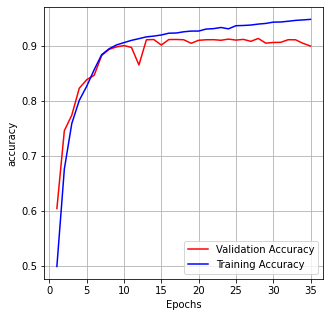

In [15]:
# saving the visulization
visulize_model(history, feature_name)

In [16]:
score, acc = complete_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', acc)
print("Test loss:", score)

Test accuracy: 0.896640419960022
Test loss: 0.5665096044540405


In [17]:
complete_peak = max(history['val_accuracy'])
print(complete_peak)

0.913281261920929


# Training with masked feature

In [10]:
already_masked = list()
counter = 0

In [11]:
len(feature_list)

52

xmeas_1
INFO:tensorflow:Assets written to: models/xmeas_1\assets


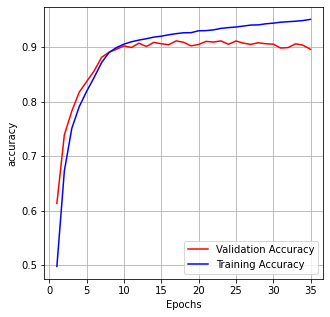


number:  1  feature name:  xmeas_1
xmeas_2
INFO:tensorflow:Assets written to: models/xmeas_2\assets


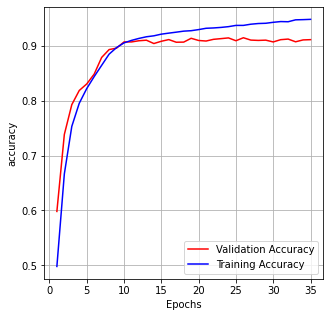


number:  2  feature name:  xmeas_2
xmeas_3
INFO:tensorflow:Assets written to: models/xmeas_3\assets


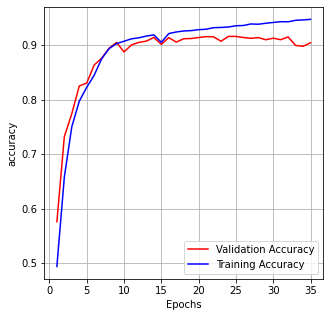


number:  3  feature name:  xmeas_3
xmeas_4
INFO:tensorflow:Assets written to: models/xmeas_4\assets


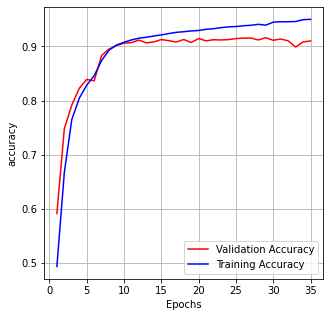


number:  4  feature name:  xmeas_4
xmeas_5
INFO:tensorflow:Assets written to: models/xmeas_5\assets


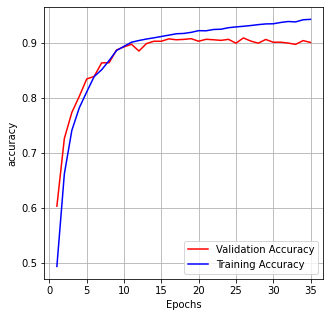


number:  5  feature name:  xmeas_5
xmeas_6
INFO:tensorflow:Assets written to: models/xmeas_6\assets


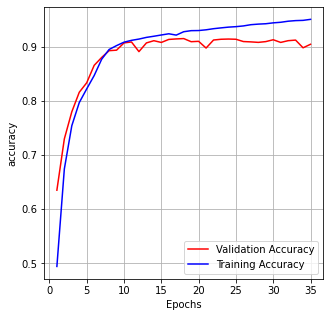


number:  6  feature name:  xmeas_6
xmeas_7
INFO:tensorflow:Assets written to: models/xmeas_7\assets


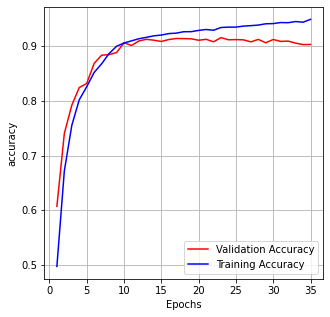


number:  7  feature name:  xmeas_7
xmeas_8
INFO:tensorflow:Assets written to: models/xmeas_8\assets


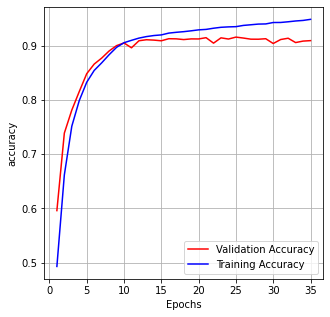


number:  8  feature name:  xmeas_8
xmeas_9
INFO:tensorflow:Assets written to: models/xmeas_9\assets


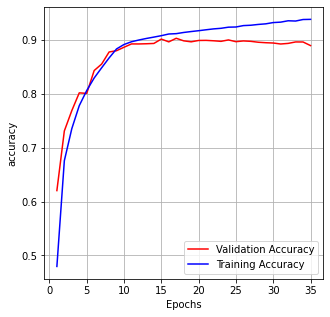


number:  9  feature name:  xmeas_9
xmeas_10
INFO:tensorflow:Assets written to: models/xmeas_10\assets


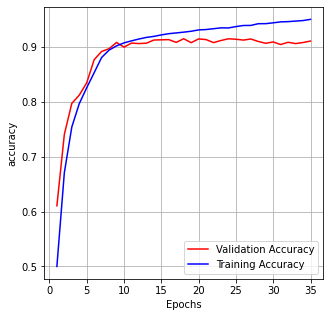


number:  10  feature name:  xmeas_10
xmeas_11
INFO:tensorflow:Assets written to: models/xmeas_11\assets


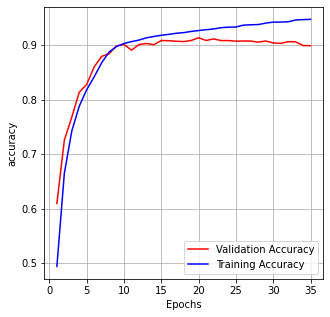


number:  11  feature name:  xmeas_11
xmeas_12
INFO:tensorflow:Assets written to: models/xmeas_12\assets


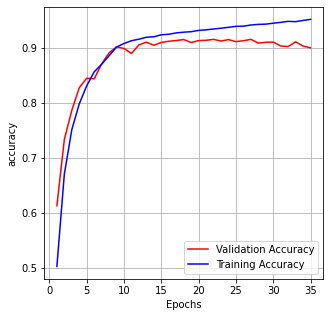


number:  12  feature name:  xmeas_12
xmeas_13
INFO:tensorflow:Assets written to: models/xmeas_13\assets


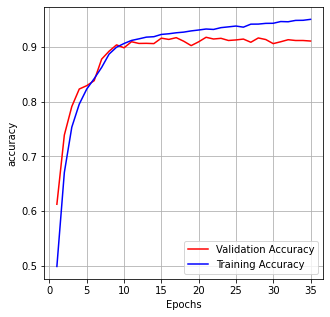


number:  13  feature name:  xmeas_13
xmeas_14
INFO:tensorflow:Assets written to: models/xmeas_14\assets


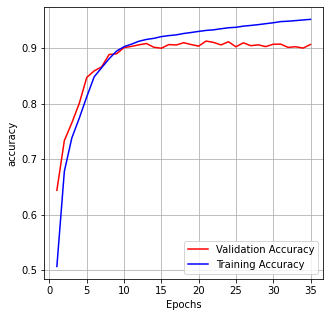


number:  14  feature name:  xmeas_14
xmeas_15
INFO:tensorflow:Assets written to: models/xmeas_15\assets


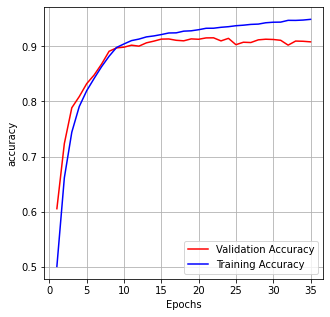


number:  15  feature name:  xmeas_15
xmeas_16
INFO:tensorflow:Assets written to: models/xmeas_16\assets


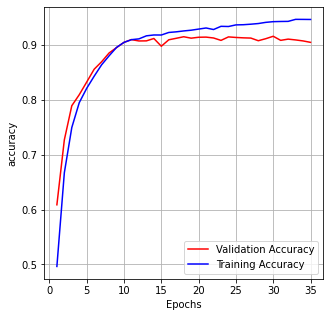


number:  16  feature name:  xmeas_16
xmeas_17
INFO:tensorflow:Assets written to: models/xmeas_17\assets


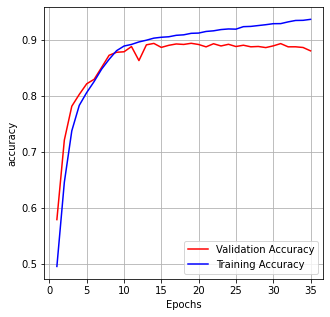


number:  17  feature name:  xmeas_17
xmeas_18
INFO:tensorflow:Assets written to: models/xmeas_18\assets


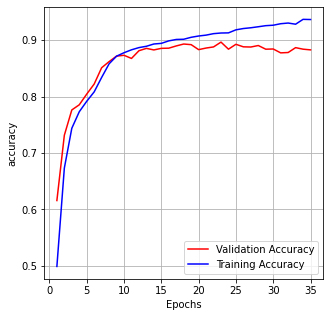


number:  18  feature name:  xmeas_18
xmeas_19
INFO:tensorflow:Assets written to: models/xmeas_19\assets


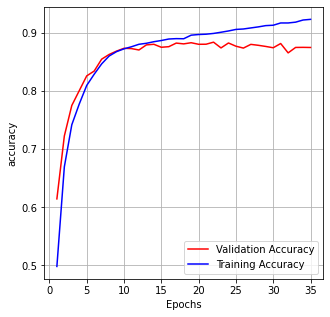


number:  19  feature name:  xmeas_19
xmeas_20
INFO:tensorflow:Assets written to: models/xmeas_20\assets


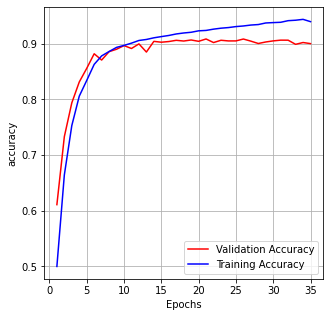


number:  20  feature name:  xmeas_20
xmeas_21
INFO:tensorflow:Assets written to: models/xmeas_21\assets


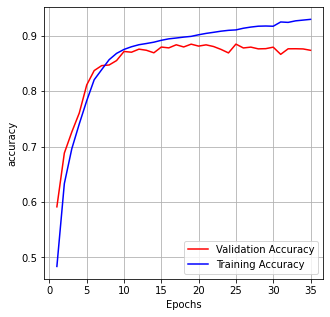


number:  21  feature name:  xmeas_21
xmeas_22
INFO:tensorflow:Assets written to: models/xmeas_22\assets


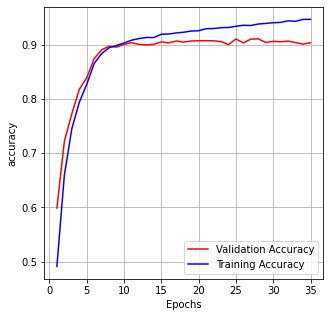


number:  22  feature name:  xmeas_22
xmeas_23
INFO:tensorflow:Assets written to: models/xmeas_23\assets


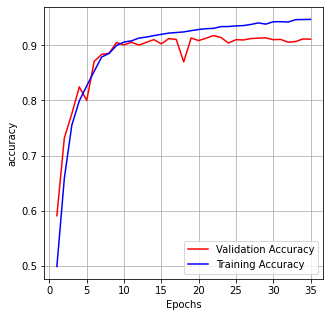


number:  23  feature name:  xmeas_23
xmeas_24
INFO:tensorflow:Assets written to: models/xmeas_24\assets


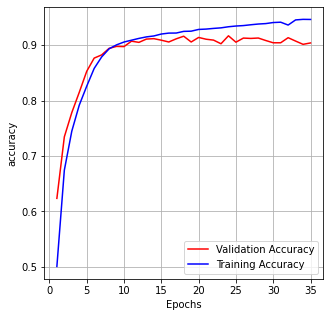


number:  24  feature name:  xmeas_24
xmeas_25
INFO:tensorflow:Assets written to: models/xmeas_25\assets


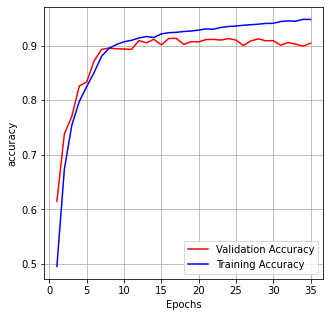


number:  25  feature name:  xmeas_25
xmeas_26
INFO:tensorflow:Assets written to: models/xmeas_26\assets


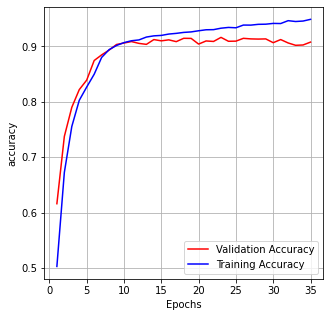


number:  26  feature name:  xmeas_26
xmeas_27
INFO:tensorflow:Assets written to: models/xmeas_27\assets


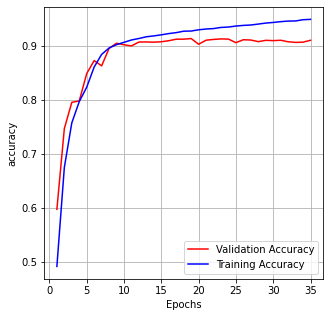


number:  27  feature name:  xmeas_27
xmeas_28
INFO:tensorflow:Assets written to: models/xmeas_28\assets


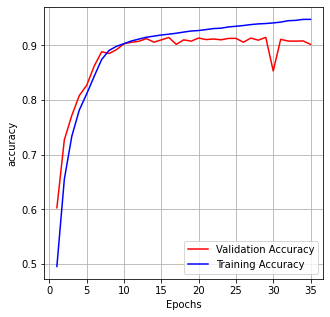


number:  28  feature name:  xmeas_28
xmeas_29
INFO:tensorflow:Assets written to: models/xmeas_29\assets


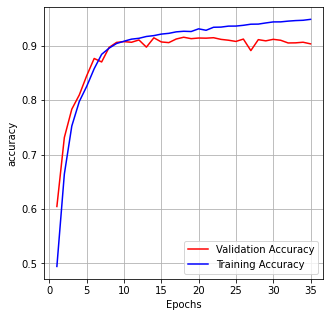


number:  29  feature name:  xmeas_29
xmeas_30
INFO:tensorflow:Assets written to: models/xmeas_30\assets


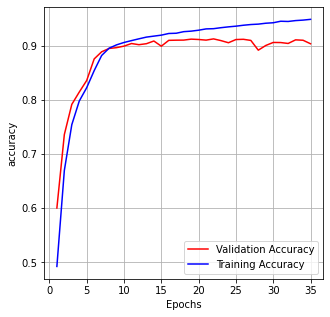


number:  30  feature name:  xmeas_30
xmeas_31
INFO:tensorflow:Assets written to: models/xmeas_31\assets


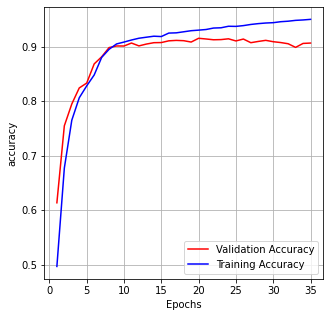


number:  31  feature name:  xmeas_31
xmeas_32
INFO:tensorflow:Assets written to: models/xmeas_32\assets


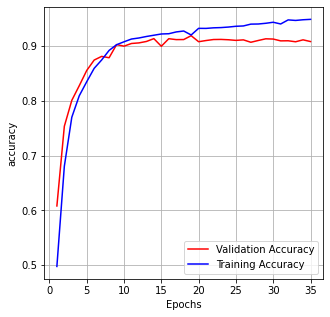


number:  32  feature name:  xmeas_32
xmeas_33
INFO:tensorflow:Assets written to: models/xmeas_33\assets


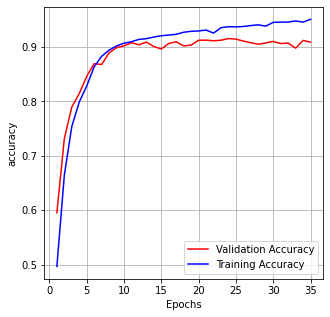


number:  33  feature name:  xmeas_33
xmeas_34
INFO:tensorflow:Assets written to: models/xmeas_34\assets


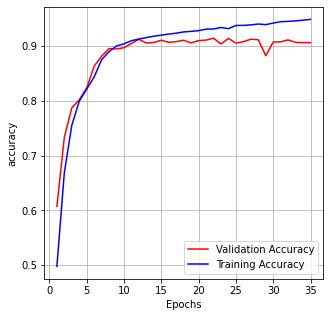


number:  34  feature name:  xmeas_34
xmeas_35
INFO:tensorflow:Assets written to: models/xmeas_35\assets


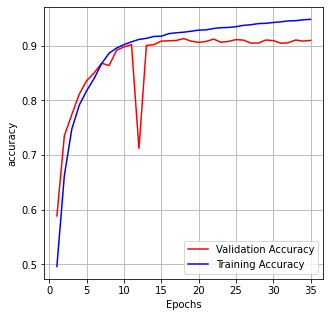


number:  35  feature name:  xmeas_35
xmeas_36
INFO:tensorflow:Assets written to: models/xmeas_36\assets


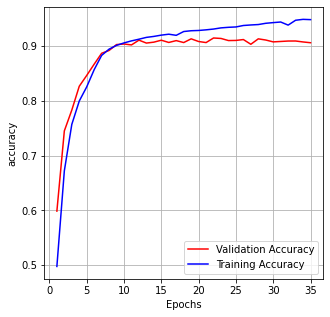


number:  36  feature name:  xmeas_36
xmeas_37
INFO:tensorflow:Assets written to: models/xmeas_37\assets


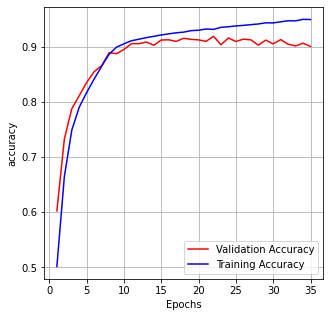


number:  37  feature name:  xmeas_37
xmeas_38
INFO:tensorflow:Assets written to: models/xmeas_38\assets


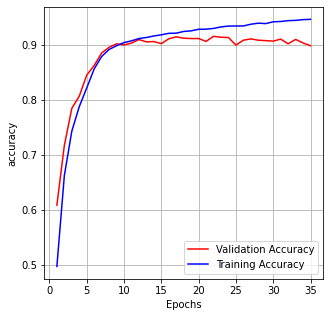


number:  38  feature name:  xmeas_38
xmeas_39
INFO:tensorflow:Assets written to: models/xmeas_39\assets


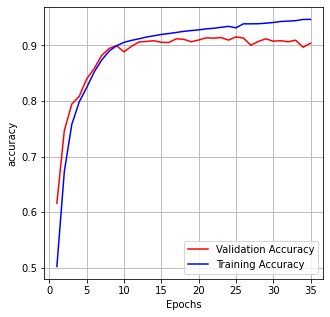


number:  39  feature name:  xmeas_39
xmeas_40
INFO:tensorflow:Assets written to: models/xmeas_40\assets


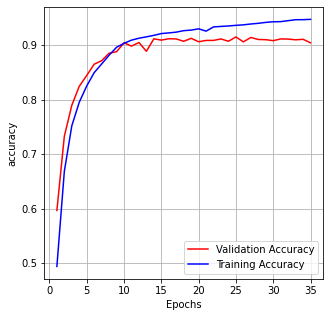


number:  40  feature name:  xmeas_40
xmeas_41
INFO:tensorflow:Assets written to: models/xmeas_41\assets


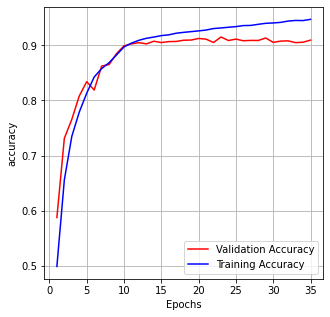


number:  41  feature name:  xmeas_41
xmv_1
INFO:tensorflow:Assets written to: models/xmv_1\assets


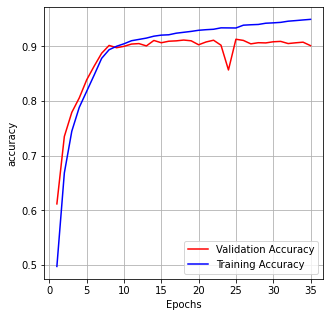


number:  42  feature name:  xmv_1
xmv_2
INFO:tensorflow:Assets written to: models/xmv_2\assets


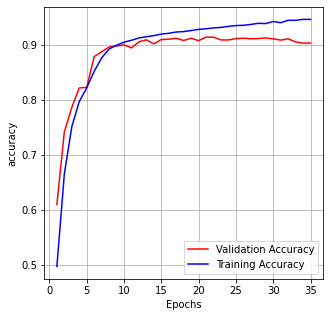


number:  43  feature name:  xmv_2
xmv_3
INFO:tensorflow:Assets written to: models/xmv_3\assets


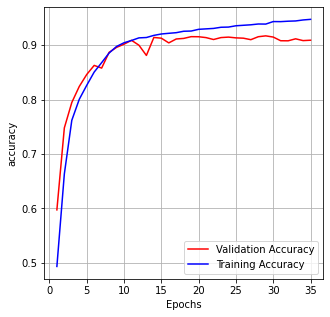


number:  44  feature name:  xmv_3
xmv_4
INFO:tensorflow:Assets written to: models/xmv_4\assets


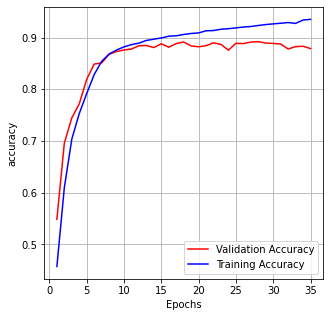


number:  45  feature name:  xmv_4
xmv_5
INFO:tensorflow:Assets written to: models/xmv_5\assets


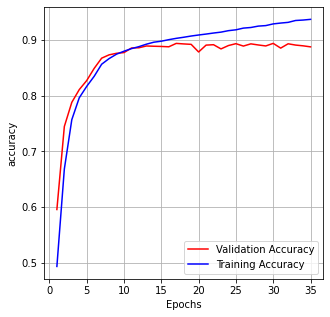


number:  46  feature name:  xmv_5
xmv_6
INFO:tensorflow:Assets written to: models/xmv_6\assets


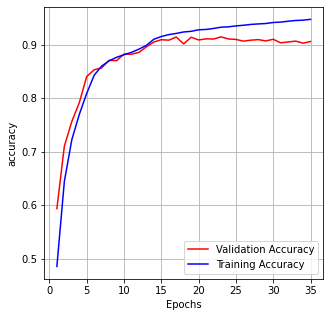


number:  47  feature name:  xmv_6
xmv_7
INFO:tensorflow:Assets written to: models/xmv_7\assets


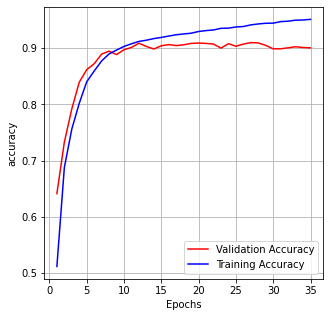


number:  48  feature name:  xmv_7
xmv_8
INFO:tensorflow:Assets written to: models/xmv_8\assets


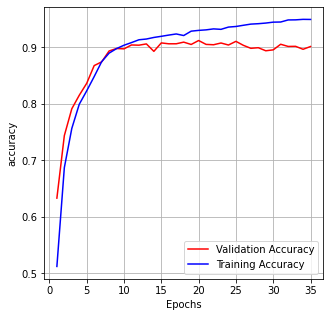


number:  49  feature name:  xmv_8
xmv_9
INFO:tensorflow:Assets written to: models/xmv_9\assets


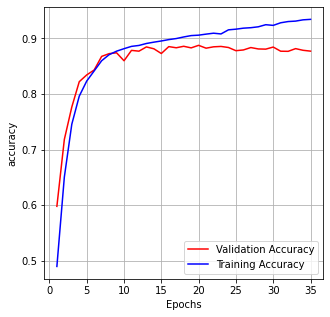


number:  50  feature name:  xmv_9
xmv_10
INFO:tensorflow:Assets written to: models/xmv_10\assets


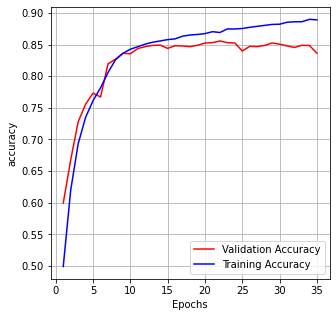


number:  51  feature name:  xmv_10
xmv_11
INFO:tensorflow:Assets written to: models/xmv_11\assets


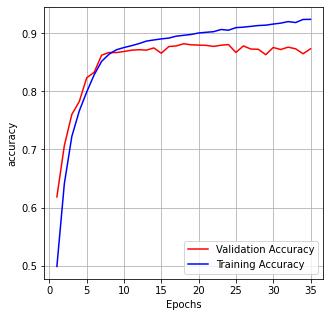


number:  52  feature name:  xmv_11


In [24]:
for masked_feature_name in feature_list:
    counter += 1
    print(masked_feature_name)
    # generate the masked matrix
    dimension, x_train, x_test, x_cv = x_generator(masked = True, feature_name = masked_feature_name)
    
    # training
    masked_model = train_model(x_train, y_train, x_cv, y_cv, dimension['train_col'], masked_feature_name)
    
    # load the history of the current model
    with open('models/' + masked_feature_name + '/history.pickle', "rb") as hisotry_file:
        history = pickle.load(hisotry_file)
    
    # saving the visulization
    visulize_model(history, masked_feature_name)
    
#     # log the test set performance
#     score, acc = complete_model.evaluate(x_test, y_test, verbose=0)
#     test_results[masked_feature_name] = (acc, score)
    
#     # log the peak validation set performance
#     val_peak = max(history['val_accuracy'])
#     val_results[masked_feature_name] = val_peak
#     val_diff[masked_feature_name] = complete_peak - val_peak
    
    # log that this feature has been masked once
    already_masked.append(masked_feature_name)
    
    print()
    print('number: ', counter, ' feature name: ', masked_feature_name)

# Visualization

#### Benchmark

In [12]:
complete_val = 0.913281261920929
complete_test = 0.896640419960022

#### Utility function

In [13]:
def plot_dict(dictionary):
    x, y = [], []
    for key, value in dictionary.items():
        x.append(key)
        y.append(value)
    return x, y

#### Log

In [14]:
test_results = dict() # keeps track of test set performance
test_diff = dict()

val_results = dict() # keeps the highest validation accuracy of a model
val_diff = dict() # keeps the difference in terms of accuracy when compared to the complete model

In [ ]:
counter = 1
for name in feature_list:
    with open('models/' + name + '/history.pickle', "rb") as hisotry_file:
        history = pickle.load(hisotry_file)
    val_acc = max(history['val_accuracy'])
    val_results[name] = val_acc
    val_diff[name] = complete_val - val_acc
    
    model = load_model('models/'+name)
    dimension, x_train, x_test, x_cv = x_generator(masked = True, feature_name = name)
    score, acc = model.evaluate(x_test, y_test, verbose=1)
    print(str(counter)+'/52')
    test_results[name] = acc
    test_diff[name] = complete_test - acc
    counter += 1

1941/2782 [===================>..........] - ETA: 2s - loss: 0.6407 - accuracy: 0.9081

#### Plotting

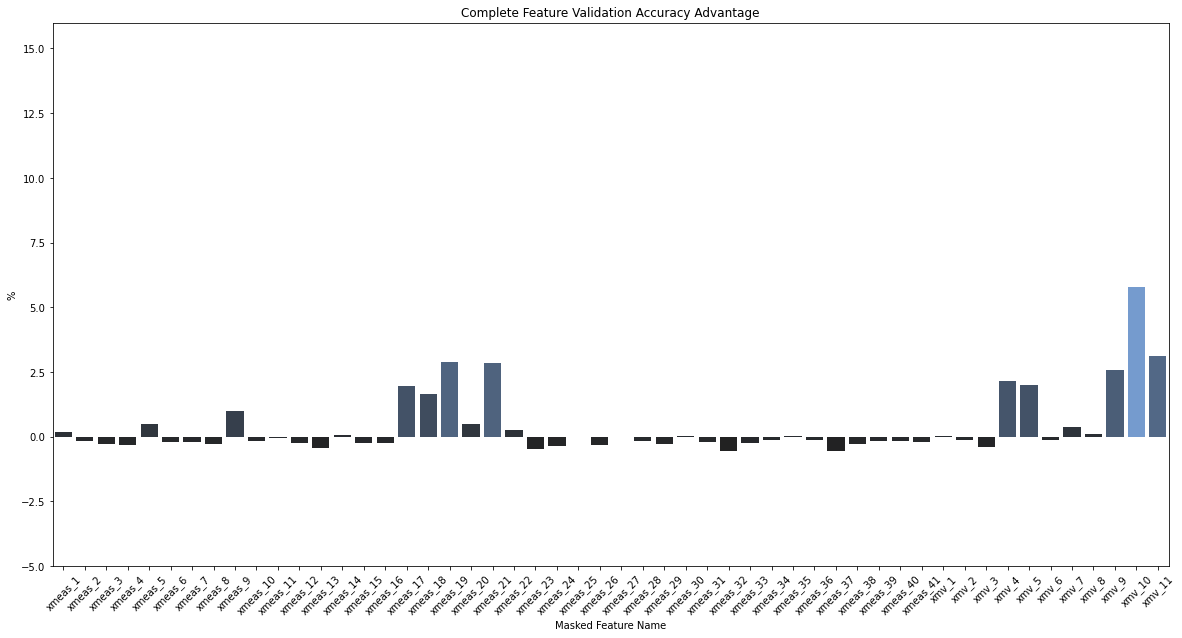

In [29]:
x_1, y_1 = plot_dict(val_diff)
y_1_100 = [z * 100 for z in y_1]
plt.figure(figsize=(20,10))
sns.barplot(x_1, y_1_100, palette = mpl.cm.ScalarMappable(cmap=sns.dark_palette("#69d", reverse=False, as_cmap=True)).to_rgba(y_1_100))
plt.xticks(rotation=45);
plt.ylim((-5.0, 16.0))
plt.title('Complete Feature Validation Accuracy Advantage')
plt.ylabel('%')
plt.xlabel('Masked Feature Name');

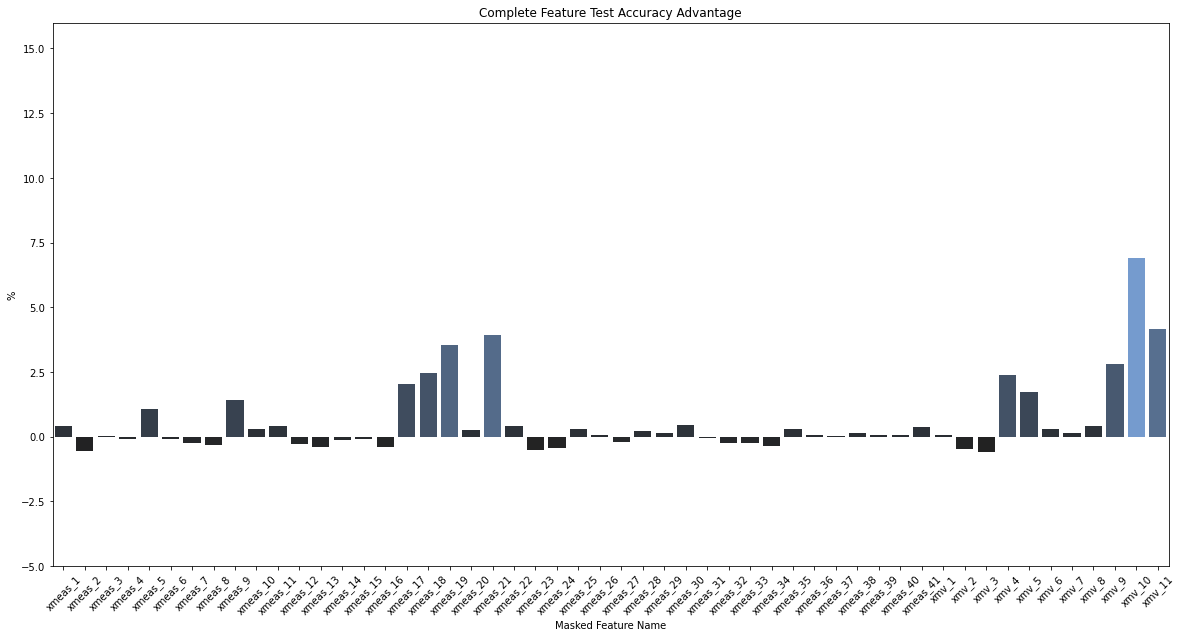

In [30]:
x_2, y_2 = plot_dict(test_diff)
y_2_100 = [z * 100 for z in y_2]
plt.figure(figsize=(20,10))
sns.barplot(x_2, y_2_100, palette = mpl.cm.ScalarMappable(cmap=sns.dark_palette("#69d", reverse=False, as_cmap=True)).to_rgba(y_2_100))
plt.xticks(rotation=45);
plt.ylim((-5.0, 16.0))
plt.title('Complete Feature Test Accuracy Advantage')
plt.ylabel('%')
plt.xlabel('Masked Feature Name');

# Prepare for EVSI

In [33]:
temp_list = sorted(val_diff.items(), key=lambda x: x[1], reverse= True)[0:10]

top_10 = list()
for the_tuple in temp_list:
    top_10.append(the_tuple[0])
top_10

random.shuffle(top_10)

top_10